# Hotel No-Show Prediction - Exploratory Data Analysis

## Objective
This notebook conducts an exploratory data analysis (EDA) of the hotel no-show prediction dataset to understand the data characteristics, identify potential issues, and inform our machine learning pipeline design.

## EDA Questions to Answer:
1. **What kind of data is this?** (file format, volume, structure)
2. **How complex is this data?** (relationships, keys, nested structures)
3. **Is this data sufficient for our goal?** (model building adequacy)
4. **Are there any missing data/values?** (completeness analysis)
5. **Are there relationships between variables?** (correlation analysis)
6. **Are observations independent?** (dependency analysis)

---


## Step 0: Imports and Reading Data

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('ggplot')
pd.set_option('display.max_columns', 20)

db_path = 'data/noshow.db'
conn = sqlite3.connect(db_path)

print("Imported successfully!")
print(f"Connected to db: {db_path}")

Imported successfully!
Connected to db: data/noshow.db


## Step 1: Data Understanding
 - Dataframe `shape`
 - `head` and `tail`
 - `dtypes`
 - `describe`

In [4]:
# Read data from the SQLite database
df = pd.read_sql_query("SELECT * FROM noshow", conn)

In [5]:
# This tells us the number of rows and columns in the dataframe
df.shape

(119391, 15)

In [6]:
# Displays the first 5 rows of the dataframe
df.head(5)

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   booking_id      119391 non-null  int64  
 1   no_show         119390 non-null  float64
 2   branch          119390 non-null  object 
 3   booking_month   119390 non-null  object 
 4   arrival_month   119390 non-null  object 
 5   arrival_day     119390 non-null  float64
 6   checkout_month  119390 non-null  object 
 7   checkout_day    119390 non-null  float64
 8   country         119390 non-null  object 
 9   first_time      119390 non-null  object 
 10  room            97778 non-null   object 
 11  price           94509 non-null   object 
 12  platform        119390 non-null  object 
 13  num_adults      119390 non-null  object 
 14  num_children    119390 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 13.7+ MB


In [8]:
df.describe()

,booking_id,no_show,arrival_day,checkout_day,num_children
count,119391.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59695.000000,0.370416,15.798241,14.250507,0.871229
std,34465.357332,0.482918,8.780829,11.063697,0.779796
min,0.000000,0.000000,1.000000,-31.000000,0.000000
25%,29847.500000,0.000000,8.000000,7.000000,0.000000
50%,59695.000000,0.000000,16.000000,15.000000,1.000000
75%,89542.500000,1.000000,23.000000,23.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,3.000000


In [9]:
# Display the column names
df.columns

Index(['booking_id', 'no_show', 'branch', 'booking_month', 'arrival_month',
       'arrival_day', 'checkout_month', 'checkout_day', 'country',
       'first_time', 'room', 'price', 'platform', 'num_adults',
       'num_children'],
      dtype='object')

In [10]:
# Datatypes of each column
df.dtypes

booking_id          int64
no_show           float64
branch             object
booking_month      object
arrival_month      object
arrival_day       float64
checkout_month     object
checkout_day      float64
country            object
first_time         object
room               object
price              object
platform           object
num_adults         object
num_children      float64
dtype: object

In [11]:
# Summary Statistics
df.describe()

,booking_id,no_show,arrival_day,checkout_day,num_children
count,119391.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59695.000000,0.370416,15.798241,14.250507,0.871229
std,34465.357332,0.482918,8.780829,11.063697,0.779796
min,0.000000,0.000000,1.000000,-31.000000,0.000000
25%,29847.500000,0.000000,8.000000,7.000000,0.000000
50%,59695.000000,0.000000,16.000000,15.000000,1.000000
75%,89542.500000,1.000000,23.000000,23.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,3.000000


## Step 2: Data Preparation
 - Identifying duplicated columns
 - Dropping irrelevant columns and rows
 - Renaming Columns
 - Feature Creation

In [12]:
df.head(20)
# Prices are in various currencies, some are null
# We probably want to convert these to 1 currency
# Number of adults are strings, some are 1 and 2 others are one and two
# We probably want to convert these to floats for better consistency with num_children

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
5,55212,0.0,Orchard,November,September,12.0,September,13.0,Indonesia,Yes,None,SGD$ 1499.61,Website,2,2.0
6,42322,0.0,Orchard,November,October,15.0,October,16.0,Australia,Yes,King,SGD$ 1375.44,Website,1,1.0
7,23137,0.0,Changi,July,November,18.0,November,19.0,India,Yes,King,None,Email,2,1.0
8,109456,1.0,Changi,January,June,27.0,June,28.0,China,Yes,None,USD$ 658.75,Email,2,1.0
9,31117,0.0,Orchard,October,March,22.0,March,24.0,China,Yes,None,USD$ 962.75,Website,1,1.0


In [13]:
# booking_id should be unique for all rows, so we can use this to check for duplicates
df.loc[df.duplicated(subset=['booking_id'])] # Noted that there are no duplicate booking ids

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children


In [14]:
print(f"Original shape: {df.shape}")
df = df[[#'booking_id', # booking_id has no predictive value
       'no_show', 
       'branch', 
       'booking_month', 
       'arrival_month',
       'arrival_day', 
       'checkout_month', 
       'checkout_day', 
       'country',
       'first_time', 
       'room', 
       'price', 
       'platform', 
       'num_adults',
       'num_children']].copy()
# We can also drop but I 
print(f"After dropping booking_id column: {df.shape}")
print(f"Data types: \n{df.dtypes}")
# Note that we may now have duplicates as in similar bookings (rows that are identical) 
# but these are actually useful for us in predicting no_shows so we will keep them

Original shape: (119391, 15)
After dropping booking_id column: (119391, 14)
Data types: 
no_show           float64
branch             object
booking_month      object
arrival_month      object
arrival_day       float64
checkout_month     object
checkout_day      float64
country            object
first_time         object
room               object
price              object
platform           object
num_adults         object
num_children      float64
dtype: object


In [15]:
# Let's look at the null values
print(f"Null values originally:")
print(f"{df.isna().sum()}") # Specifically, we have null values in no_show, our target variable

# Let's explore the row with null value in no_show
df.loc[df['no_show'].isnull()] # This row has all null values, we can safely drop it

Null values originally:
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64


,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
111598,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None,None,NaN


In [16]:
# Now we've located the problem row, we can drop it
print(f"Original shape: {df.shape}")
df = df.drop(index=111598) \
    .reset_index(drop=True)
# Drop the problematic row by its index and reset index
# Alternatively: df = df.dropna(how='all') # Drops rows with all null values like our case
print(f"After dropping problematic row: {df.shape}")

# We check the null values again
print(f"Null values AFTER DROPPING:")
print(f"{df.isna().sum()}") # Nice

# We also check target variable distribution, we are concerned with class no_show=1.0
print(f"Target variable distribution:")
print(f"{df['no_show'].value_counts()}")

Original shape: (119391, 14)
After dropping problematic row: (119390, 14)
Null values AFTER DROPPING:
no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room              21612
price             24881
platform              0
num_adults            0
num_children          0
dtype: int64
Target variable distribution:
no_show
0.0    75166
1.0    44224
Name: count, dtype: int64


In [17]:
# Extract and convert prices to SGD
def price_to_sgd(price_str):
    if pd.isna(price_str) or str(price_str).lower() == 'none':
        return np.nan
    price_str = str(price_str)
    if 'USD$' in price_str:
        return round(float(price_str.replace('USD$', '').strip()) * 1.35, 2) # 2dp
    elif 'SGD$' in price_str:
        return round(float(price_str.replace('SGD$', '').strip()), 2)
    return np.nan
# Standardized Price_SGD column, float so we can use it for analysis
df['Price_SGD'] = df['price'].apply(price_to_sgd)
# df.dtypes
# df.head(10)

In [18]:
# We want to make sure that we don't have any rows where both price and room are missing
# Prices are based on branch, room and length of stay
price_and_room_missing = df['room'].isna() & df['price'].isna()
print(f"\nBoth room and price missing: {price_and_room_missing.sum()} rows")
# We have determined that there are no rows where both price and room are missing
# If price is missing, there is at least a room value
# If necessary, we can use branch, room and length of stay to impute price
# We will skip this for now so we don't introduce imputation bias

print(f"Price available: {(~df['Price_SGD'].isna()).sum()} rows ({(~df['Price_SGD'].isna()).sum()/len(df)*100:.1f}%)")
print(f"Price missing: {df['Price_SGD'].isna().sum()} rows ({df['Price_SGD'].isna().sum()/len(df)*100:.1f}%)")

df['Price_Missing'] = df['Price_SGD'].isna().astype(int)

# We could now drop the original price column
# df = df.drop(columns=['price']) # but we will keep it for now


Both room and price missing: 0 rows
Price available: 94509 rows (79.2%)
Price missing: 24881 rows (20.8%)


In [19]:
print("No Show Rates:")
print(f"Price available: {df[~df['Price_SGD'].isna()]['no_show'].mean():.3f}")
print(f"Price missing: {df[df['Price_SGD'].isna()]['no_show'].mean():.3f}")
# 


No Show Rates:
Price available: 0.370
Price missing: 0.372


In [20]:
# Rename columns
df.rename(columns={'no_show': 'No_Show', 'branch': 'Branch', 'booking_month': 'Booking_Month', 'arrival_month': 'Arrival_Month', 'arrival_day': 'Arrival_Day', 'checkout_month': 'Checkout_Month', 'checkout_day': 'Checkout_Day', 'country': 'Country', 'first_time': 'First_Time', 'room': 'Room', 'price': 'Price', 'platform': 'Platform', 'num_adults': 'Num_Adults', 'num_children': 'Num_Children'}, inplace=True)

In [21]:
# Convert Num_Adults to float
df['Num_Adults'] = df['Num_Adults'].fillna('0') # we already handled this
num_adults_counts = df['Num_Adults'].value_counts()
print(f"Num_Adults counts: \n{num_adults_counts}")

df['Num_Adults'] = df['Num_Adults'].astype(str).str.replace('one', '1').str.replace('two', '2')
df['Num_Adults'] = df['Num_Adults'].astype(int)
print(f"Data types: \n{df.dtypes}")
print(f"\n{df['Num_Adults'].value_counts()}")

Num_Adults counts: 
Num_Adults
1      62745
2      45243
one     6334
two     5068
Name: count, dtype: int64
Data types: 
No_Show           float64
Branch             object
Booking_Month      object
Arrival_Month      object
Arrival_Day       float64
Checkout_Month     object
Checkout_Day      float64
Country            object
First_Time         object
Room               object
Price              object
Platform           object
Num_Adults          int64
Num_Children      float64
Price_SGD         float64
Price_Missing       int64
dtype: object

Num_Adults
1    69079
2    50311
Name: count, dtype: int64


In [22]:
# At this point, we should probably just convert all floats to ints (except for Price_SGD)
df['No_Show'] = df['No_Show'].astype(int)
df['Arrival_Day'] = df['Arrival_Day'].astype(int)
df['Checkout_Day'] = df['Checkout_Day'].astype(int)
df['Num_Children'] = df['Num_Children'].astype(int)

# df.head()

In [23]:
# Check the float values
print(f"\nArrival_Day: \n{df['Arrival_Day'].describe()}")
print(f"\nCheckout_Day: \n{df['Checkout_Day'].describe()}") # Clearly something wrong with this
print(f"\nNum_Adults: \n{df['Num_Adults'].describe()}")
print(f"\nNum_Children: \n{df['Num_Children'].describe()}")
print(f"\nPrice_SGD: \n{df['Price_SGD'].describe()}")

# Let's do a simple fix for negative Checkout_Day values
df['Checkout_Day'] = df['Checkout_Day'].abs().clip(1,31)


Arrival_Day: 
count    119390.000000
mean         15.798241
std           8.780829
min           1.000000
25%           8.000000
50%          16.000000
75%          23.000000
max          31.000000
Name: Arrival_Day, dtype: float64

Checkout_Day: 
count    119390.000000
mean         14.250507
std          11.063697
min         -31.000000
25%           7.000000
50%          15.000000
75%          23.000000
max          31.000000
Name: Checkout_Day, dtype: float64

Num_Adults: 
count    119390.000000
mean          1.421400
std           0.493786
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: Num_Adults, dtype: float64

Num_Children: 
count    119390.000000
mean          0.871229
std           0.779796
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: Num_Children, dtype: float64

Price_SGD: 
count    94509.000000
mean       942.242586
std      

In [24]:
# Minimal feature engineering

# Calculate length of stay
# The assumption here is a min stay of 1 day and a max stay of 30 days
# This doesn't work well for cases where Checkout_Day values are smaller than Arrival_Day
df['Length_of_Stay'] = (df['Checkout_Day'] - df['Arrival_Day']).abs().clip(1,30)

# Num_Guests is the sum of Num_Adults and Num_Children
df['Num_Guests'] = df['Num_Adults'] + df['Num_Children']

df.head(20)

,No_Show,Branch,Booking_Month,Arrival_Month,Arrival_Day,Checkout_Month,Checkout_Day,Country,First_Time,Room,Price,Platform,Num_Adults,Num_Children,Price_SGD,Price_Missing,Length_of_Stay,Num_Guests
0,0,Changi,November,June,25,June,27,Singapore,Yes,Single,SGD$ 492.98,Website,1,0,492.98,0,2,1
1,0,Orchard,August,November,28,November,29,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0,1351.22,0,1,2
2,0,Changi,March,February,7,February,11,India,Yes,Single,None,Agent,1,0,NaN,1,4,1
3,1,Orchard,September,October,1,October,3,China,Yes,Single,SGD$ 666.04,Website,1,0,666.04,0,2,1
4,0,Orchard,March,June,20,June,24,Australia,Yes,Queen,USD$ 665.37,Website,1,0,898.25,0,4,1
5,0,Orchard,November,September,12,September,13,Indonesia,Yes,None,SGD$ 1499.61,Website,2,2,1499.61,0,1,4
6,0,Orchard,November,October,15,October,16,Australia,Yes,King,SGD$ 1375.44,Website,1,1,1375.44,0,1,2
7,0,Changi,July,November,18,November,19,India,Yes,King,None,Email,2,1,NaN,1,1,3
8,1,Changi,January,June,27,June,28,China,Yes,None,USD$ 658.75,Email,2,1,889.31,0,1,3
9,0,Orchard,October,March,22,March,24,China,Yes,None,USD$ 962.75,Website,1,1,1299.71,0,2,2


In [25]:
# Target variable analysis
print(f"No Show Rate: {df['No_Show'].mean():.2%}")
print(f"\nClass distribution: \n{df['No_Show'].value_counts(normalize=True)}")
print(f"\nClass imbalance ratio: {df['No_Show'].value_counts().max() / df['No_Show'].value_counts().min():.2f}")


No Show Rate: 37.04%

Class distribution: 
No_Show
0    0.629584
1    0.370416
Name: proportion, dtype: float64

Class imbalance ratio: 1.70


## Step 3: Feature Understanding
(Univariate Analysis)
 - Plotting feature distributions
    - Bar
    - KDE
    - Boxplot

In [26]:
# df['Arrival_Month'].value_counts() # clear data quality issues here
# df['Checkout_Month'].value_counts() # this appears to be fine
# df['Booking_Month'].value_counts() # this appears to be fine

# Before
print(f"BEFORE FIX - Unique Arrival_Month values: {df['Arrival_Month'].nunique()}")

# Fix Arrival_Month
df['Arrival_Month'] = df['Arrival_Month'].str.lower().str.capitalize()

# After
print(f"\nAFTER FIX - Unique Arrival_Month values: {df['Arrival_Month'].nunique()}")
print(f"\nArrival_Month Counts: \n{df['Arrival_Month'].value_counts()}")


BEFORE FIX - Unique Arrival_Month values: 88

AFTER FIX - Unique Arrival_Month values: 12

Arrival_Month Counts: 
Arrival_Month
August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: count, dtype: int64


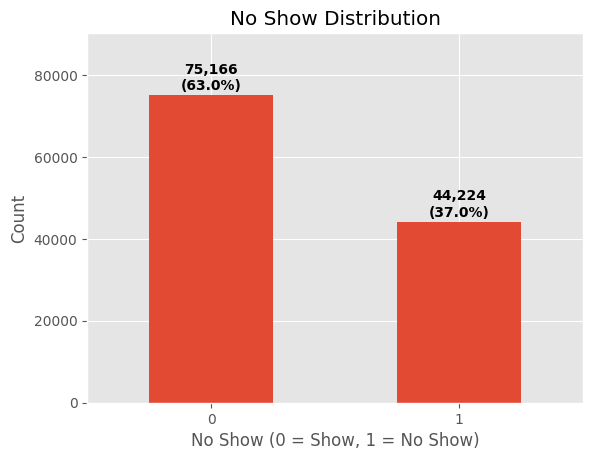

In [27]:
# We use a car chart because binary classification, not continuous
counts = df['No_Show'].value_counts()
total = len(df)

ax = counts.plot(kind='bar', title='No Show Distribution')
ax.set_xlabel('No Show (0 = Show, 1 = No Show)')
ax.set_ylabel('Count')

for i, (bar, count) in enumerate(zip(ax.patches, counts.values)):
    percentage = (count / total) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f'{count:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

ax.set_ylim(0, max(counts.values) * 1.20)
plt.xticks(rotation=0)
plt.show()

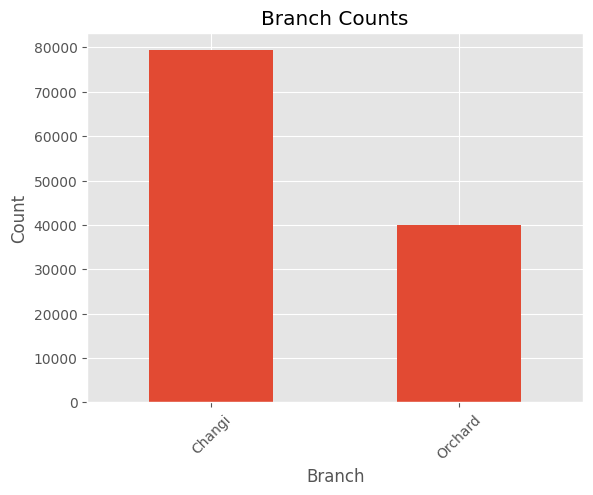

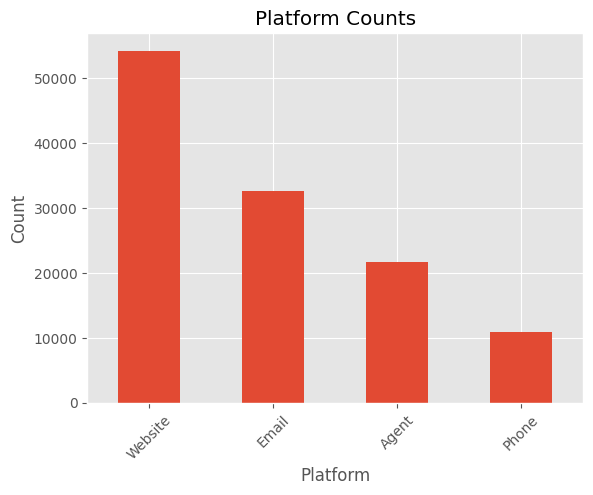

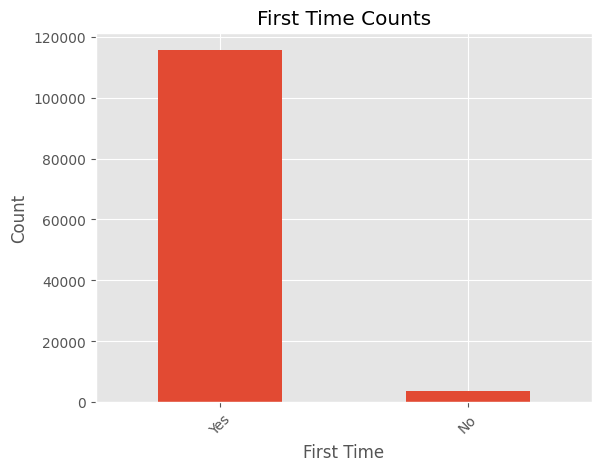

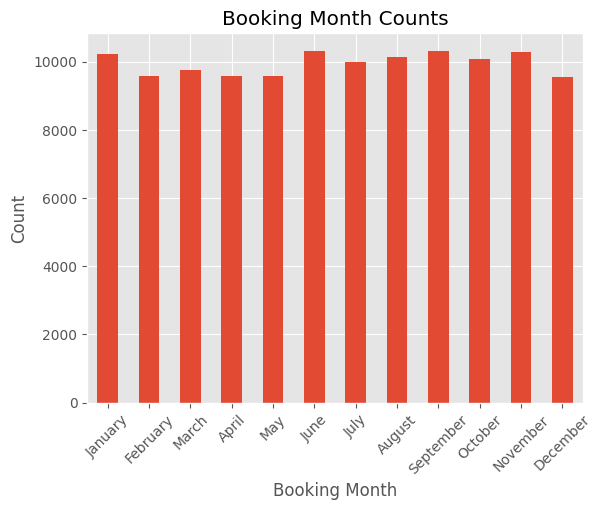

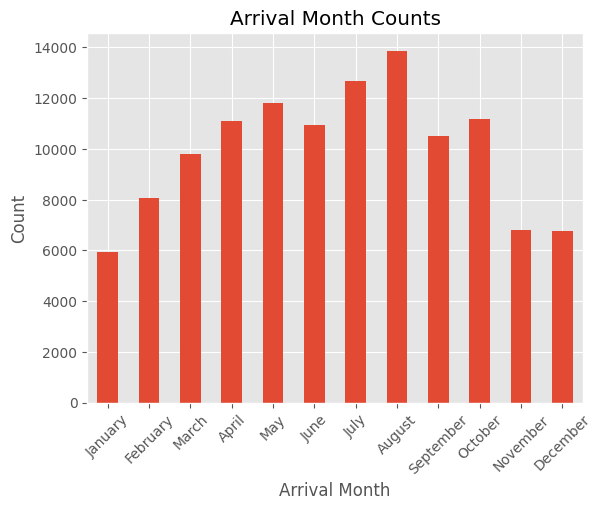

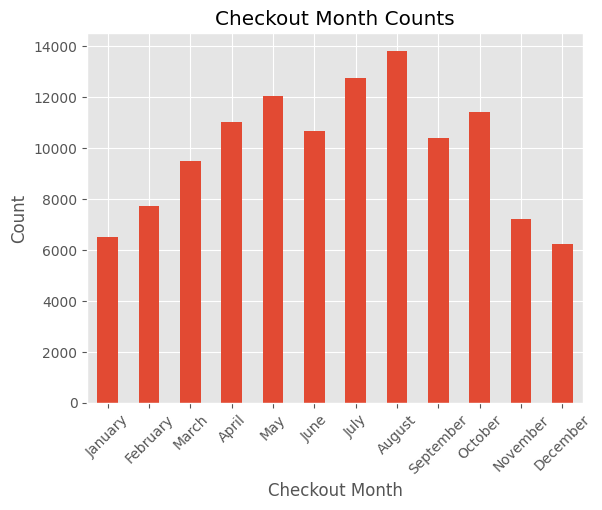

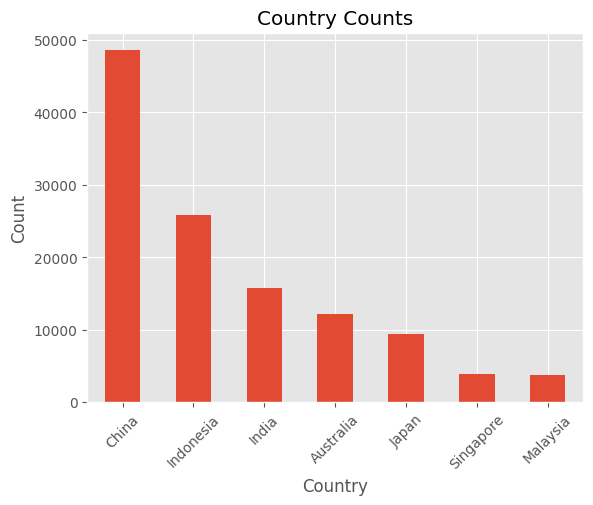

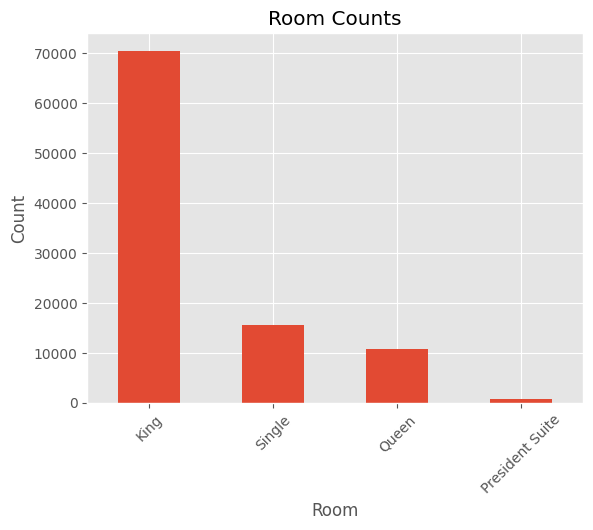

In [28]:
## Categorical Features

# Branch counts
ax = df['Branch'].value_counts().plot(kind='bar', title='Branch Counts')
ax.set_xlabel('Branch')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Platform counts
ax = df['Platform'].value_counts().plot(kind='bar', title='Platform Counts')
ax.set_xlabel('Platform')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# First time counts
ax = df['First_Time'].value_counts().plot(kind='bar', title='First Time Counts')
ax.set_xlabel('First Time')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Order by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Booking Month counts
ax = df['Booking_Month'].value_counts().reindex(month_order).plot(kind='bar', title='Booking Month Counts')
ax.set_xlabel('Booking Month')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Arrival Month counts
ax = df['Arrival_Month'].value_counts().reindex(month_order).plot(kind='bar', title='Arrival Month Counts')
ax.set_xlabel('Arrival Month')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Checkout Month counts
ax = df['Checkout_Month'].value_counts().reindex(month_order).plot(kind='bar', title='Checkout Month Counts')
ax.set_xlabel('Checkout Month')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Country counts
ax = df['Country'].value_counts().plot(kind='bar', title='Country Counts')
ax.set_xlabel('Country')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Room counts
ax = df['Room'].value_counts().plot(kind='bar', title='Room Counts')
ax.set_xlabel('Room')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()


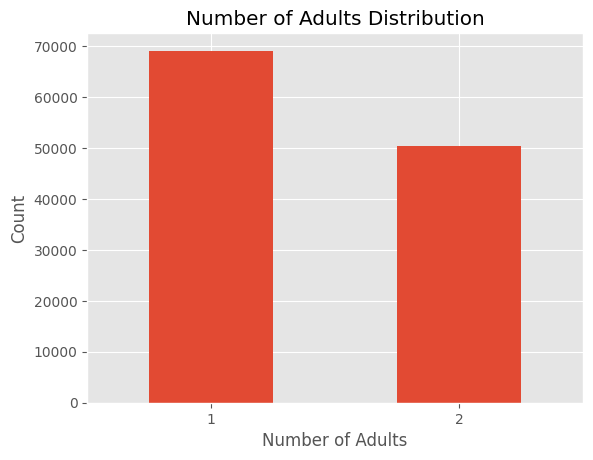

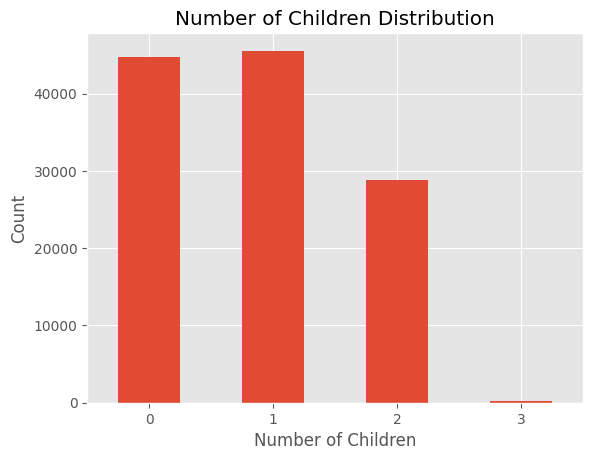

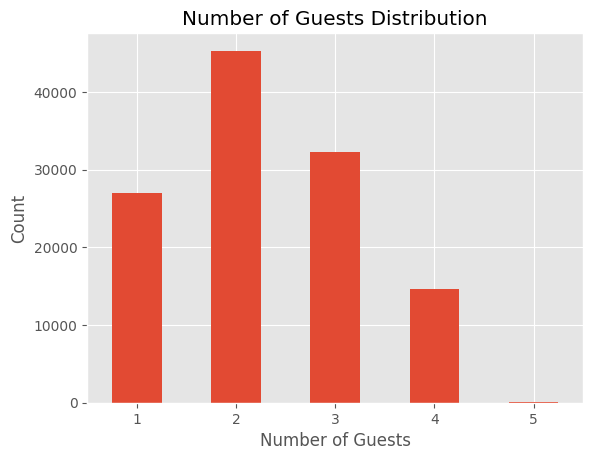

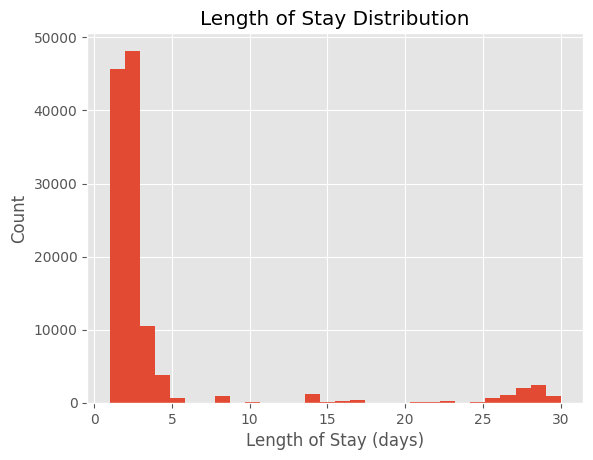

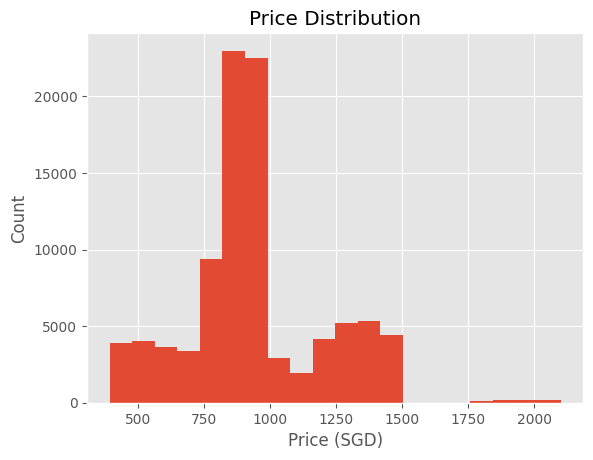

In [35]:
## Numerical Features

# Number of Adults
ax = df['Num_Adults'].value_counts().plot(kind='bar', title='Number of Adults Distribution')
ax.set_xlabel('Number of Adults')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Number of Children
ax = df['Num_Children'].value_counts().sort_index().plot(kind='bar', title='Number of Children Distribution')
ax.set_xlabel('Number of Children')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Number of Guests
ax = df['Num_Guests'].value_counts().sort_index().plot(kind='bar', title='Number of Guests Distribution')
ax.set_xlabel('Number of Guests')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Length of Stay
ax = df['Length_of_Stay'].plot(kind='hist', title='Length of Stay Distribution', bins=30)
ax.set_xlabel('Length of Stay (days)')
ax.set_ylabel('Count')
plt.show()

# Price SGD
ax = df['Price_SGD'].plot(kind='hist', title='Price Distribution', bins=20)
ax.set_xlabel('Price (SGD)')
ax.set_ylabel('Count')
plt.show()



## Step 4: Feature Relationships

 - Scatterplot
 - Heatmap Correlation
 - Pairplot
 - Groupby comparisons
    